In [10]:
%matplotlib inline
from datavyz import ge

Need to be in parent directory (e.g. cd ..)

In [277]:
cd /home/yann/work/zinc-NMDA-modulation/

/home/yann/work/zinc-NMDA-modulation


In [278]:
### Running scans over grids for model parameters
from model import Model # the grid bounds are stored in the model file

import numpy as np
import os
from analyz.workflow.batch_run import GridSimulation, bash_script

## ZINC-MODULATION PROPS
GRID = {'alphaZn':np.linspace(Model['alphaZn_min'], Model['alphaZn_max'], Model['N_alphaZn']),
        'tauRiseZn':np.linspace(Model['tauRiseZn_min'],Model['tauRiseZn_max'], Model['N_tauRiseZn']),
        'tauDecayZn':np.linspace(Model['tauDecayZn_min'], Model['tauDecayZn_max'], Model['N_tauDecayZn']),
        # 'Deltax0':np.linspace(Model['Deltax0_min'], Model['Deltax0_max'], Model['N_Deltax0']),
        # 'x0':np.linspace(Model['x0_min'], Model['x0_max'], Model['N_x0']),
        # 'deltax':np.linspace(Model['deltax_min'], Model['deltax_max'], Model['N_deltax']),
        'x0':np.linspace(Model['x0_min'], Model['x0_max'], Model['N_x0'])}

from numpy import array
GRID = {'alphaZn': array([0.15, 0.22, 0.29, 0.36, 0.43, 0.5 , 0.57]),
        'tauRiseZn': array([ 5., 14., 23., 32., 41., 50., 59.]),
        'tauDecayZn': array([ 50., 140., 230., 320., 410., 500., 590.]),
        'x0': array([0.4, 0.5, 0.6])}


np.savez(os.path.join('data', 'calib', 'free-zinc-calib-grid.npz'), **GRID)

# Making a bash script to run a scan on the above grid grid
sim = GridSimulation(GRID) # os.path.join('..', 'data', 'calib', 'passive-grid.npz'))
bs = bash_script('calib-free-zinc')
bs.script = sim.build_script('python calibration_runs.py free-zinc-calib',
                             base_script=bs.script, simultaneous_runs=3*8)
bs.write(folder='bash/')

In [197]:
GRID

{'alphaZn': array([0.15, 0.22, 0.29, 0.36, 0.43, 0.5 , 0.57]),
 'tauRiseZn': array([ 5., 14., 23., 32., 41., 50., 59.]),
 'tauDecayZn': array([ 50., 140., 230., 320., 410., 500., 590.]),
 'x0': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8])}

In [27]:
from analyz.IO.npz import load_dict
D = load_dict('./data/calib/best-freeZn-config.npz')
for key in D:
    print(key, ' -> ', D[key])

grid_index  ->  498
filename  ->  data/calib/alphaZn_0.220000--tauRiseZn_59.000000--tauDecayZn_590.000000--x0_0.300000.npz
alphaZn  ->  0.22
tauRiseZn  ->  59.0
tauDecayZn  ->  590.0
x0  ->  0.3


In [6]:
import os
import numpy as np
from analyz.workflow.batch_run import slurm_script, bash_script, GridSimulation
from analyz.IO.npz import load_dict

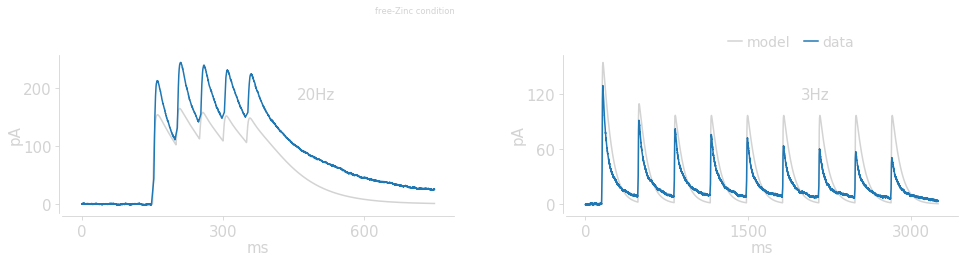

In [279]:
from datavyz import gedn as ge
from analyz.IO.npz import load_dict
fig, AX = ge.figure(axes=(2,1), figsize=(1.2,0.8),
                    wspace=0.5, hspace=0)

calib_data = load_dict('./data/exp_data_for_calibration.npz')
mdata = load_dict('./'+load_dict('./data/calib/best-freeZn-config.npz')['filename'])

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AX):
    ## data
    tcond = (mdata['t']>(mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (mdata['t']<mdata['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = -1e3*(mdata['Ic'][tcond]-mdata['Ic'][tcond][0])
    trace_exp = calib_data['Iexp_freeZn_%s' % cond]
    
    ax.plot(calib_data['t_%s' % cond], trace_model, color=ge.default_color, label='model')
    ax.plot(calib_data['t_%s' % cond], trace_exp, color=ge.blue, label='data')

    ge.set_plot(ax, ylabel='pA', xlabel='ms')
    ge.annotate(ax, cond.split('_')[0], (.6, .7))
    
ge.legend(AX[1], size='small', loc=(0.4,1.), ncol=2)
fig.suptitle('free-Zinc condition', color=ge.default_color, size='small');

0.2387517672489029


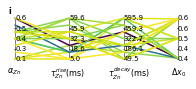

In [287]:
SUFFIX = ''

from analyz.IO.npz import load_dict
from datavyz import ge
calib_data = load_dict('./data/exp_data_for_calibration.npz')
Residuals = np.load('./data/calib/freeZn-residuals%s.npy' % SUFFIX)
sim = GridSimulation(os.path.join('data', 'calib', 'free-zinc-calib-grid%s.npz' % SUFFIX))
D, X, COLORS = {}, [], []

Nplot = 20
#np.random.seed(3)
pResiduals = np.ones(Nplot+1)*np.inf
for j, i in enumerate(np.random.choice(np.arange(int(sim.N)), Nplot)):
    pResiduals[j] = np.log10(Residuals[i])
    pResiduals[j] = Residuals[i]
    sim.update_dict_from_GRID_and_index(i, D)
    X.append([D[k] for k in sim.GRID])
D = load_dict('./data/calib/best-freeZn-config%s.npz' % SUFFIX)
X.append([D[k] for k in sim.GRID])
pResiduals[-1] = np.min(Residuals)
print(np.min(Residuals))
Colors = (pResiduals-pResiduals.min())/(pResiduals.max()-pResiduals.min())
fig31, ax = ge.parallel_plot(X,
                 SET_OF_LABELS=['$\\alpha_{Zn}$', '$\\tau_{Zn}^{rise}$(ms)  ','    $\\tau_{Zn}^{decay}$(ms)',
                                '$\Delta x_0$', '$\\delta x$'], lw=1.5, 
                 COLORS=[ge.viridis_r(c) for c in Colors])
ge.top_left_letter(ax, 'i', loc=(-0.02,1.))
ge.savefig(fig31, 'model-calibration/figures/fig31.svg')

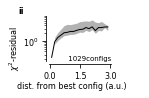

In [281]:
SUFFIX = ''
best = load_dict('data/calib/best-freeZn-config%s.npz' % SUFFIX)
D = {}
norm = {}
for k in sim.GRID:
    norm[k]=(sim.GRID[k][-1]-sim.GRID[k][0])
    
def distance_from_best_config(best, new):
    distance = 0
    for k in sim.GRID:
        distance += (best[k]-new[k])**2/norm[k]**2
    return distance

Residuals = np.load(os.path.join('data', 'calib', 'freeZn-residuals%s.npy' % SUFFIX))
Distance = np.zeros(sim.N)
for i in np.arange(int(sim.N)):
    sim.update_dict_from_GRID_and_index(i, D)
    Distance[i] = distance_from_best_config(best, D)

bins = np.linspace(0, Distance.max(), 20)
ibins = np.digitize(Distance, bins=bins, right=True)
d, r, sr, sr1, sr2 = [], [], [], [], []
for i, b in enumerate(bins[:-1]):
    d.append(.5*(bins[i]+bins[i+1]))
    r.append(np.mean(Residuals[ibins==i]))
    sr.append(np.std(Residuals[ibins==i]))
    cond = Residuals[ibins==i]<r[-1]
    sr1.append(np.std(Residuals[ibins==i][cond]))
    cond = Residuals[ibins==i]>=r[-1]
    sr2.append(np.std(Residuals[ibins==i][cond]))

fig32, ax = ge.plot(d, r, sy1=np.array(sr1), sy2=np.array(sr2),
        axes_args=dict(ylabel='$\chi^2$-residual        ',
                       # yticks=[2,4,8], yticks_labels=['2','4','8'], ylim=[1.8, 8],
                       xlabel='dist. from best config (a.u.)      ', yscale='log'))
ge.annotate(ax, ' %iconfigs' % sim.N, (1., 0.), size='small', va='bottom', ha='right')
ge.top_left_letter(ax, 'ii', loc=(-0.4,1.))
ge.savefig(fig32, 'model-calibration/figures/fig32.svg')

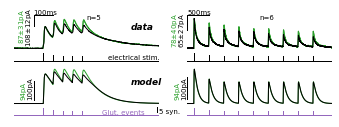

In [282]:
from analyz.IO.npz import load_dict
from datavyz import ge

SUFFIX = ''
MDATA = {'free':load_dict('./'+load_dict('./data/calib/best-freeZn-config%s.npz' % SUFFIX)['filename']),
         'chelated':load_dict('./'+load_dict('./data/best_chelatedZn_config.npz')['filename'])}
FDATA = load_dict('./data/full_data_for_calibration.npz')

fig, AX = ge.figure(axes_extents=[[[1,7],[1,7]],
                                  [[1,2],[1,2]],
                                  [[1,1],[1,1]],
                                  [[1,7],[1,7]],
                                  [[1,2],[1,2]]],
                    figsize=(1.55,0.12),
                    wspace=0.3, hspace=0, right=0.)

for ax in AX[2]:
    ax.axis('off')

for cond, ax, ax1, ax2, ax3, I0, t0, DI, T in zip(['20Hz_protocol', '3Hz_protocol'],
                                                  AX[0], AX[1], AX[3], AX[4], [1.5, 1.1],
                                                  [100, 0], [0.5, 0.5], [100, 500]):

    ## exp
    ax.plot(FDATA[cond]['t'][0]+t0+np.zeros(2), [I0,I0-DI], lw=1, color=ge.default_color)
    ax.plot(FDATA[cond]['t'][0]+t0+np.arange(2)*T, [I0, I0], lw=1, color=ge.default_color)
    ge.annotate(ax, '%.0f$\pm$%.0fpA' % (1e3*FDATA[cond]['scale_freeZn'].mean()*DI,
                1e3*FDATA[cond]['scale_freeZn'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', va='center', size='small')
    ge.annotate(ax, '%.0f$\pm$%.0fpA\n' % (1e3*FDATA[cond]['scale_chelatedZn'].mean()*DI,
                1e3*FDATA[cond]['scale_chelatedZn'].std()*DI),
                (FDATA[cond]['t'][0]+t0, I0-DI), xycoords='data', rotation=90,
                ha='right', color=ge.green, va='center', size='small')
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_chelatedZn'].mean(axis=0),
            sy=0*FDATA[cond]['norm_trace_chelatedZn'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_chelatedZn'].mean(axis=0),
            sy=0*FDATA[cond]['norm_trace_chelatedZn'].std(axis=0), ax=ax, color=ge.green)
    ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_freeZn'].mean(axis=0),
            sy=0*FDATA[cond]['norm_trace_freeZn'].std(axis=0), ax=ax)
    # ge.plot(FDATA[cond]['t'], FDATA[cond]['norm_trace_chelatedZn'].mean(axis=0)-
    #         FDATA[cond]['norm_trace_freeZn'].mean(axis=0), ax=ax, color=ge.red)
    ge.annotate(ax, 'n=%i' % len(FDATA[cond]['norm_trace_freeZn']), (.5,.8), size='small')
    ge.annotate(ax, '%ims' % T, (FDATA[cond]['t'][0]+t0, I0), xycoords='data', size='small')
    ge.set_plot(ax,[], xlim=[FDATA[cond]['t'][0], FDATA[cond]['t'][-1]])

    ## model
    DT0 = FDATA[cond]['t'][FDATA[cond]['se'][0]]-FDATA[cond]['t'][0]
    DTfull = FDATA[cond]['t'][-1]-FDATA[cond]['t'][0]

    tcond = (MDATA['free']['t']>(MDATA['free']['%s_tstart' % cond]-DT0)) &\
        (MDATA['free']['t']<(MDATA['free']['%s_tstart' % cond]-DT0+DTfull))

    trace_chelatedZn = -1e3*(MDATA['chelated']['Ic'][tcond]-MDATA['chelated']['Ic'][tcond][0])
    trace_freeZn = -1e3*(MDATA['free']['Ic'][tcond]-MDATA['free']['Ic'][tcond][0])
    
    # norm
    tarray, ta0, window_for_peak = MDATA['free']['t'][tcond], 150, 20
    peak_cond = (tarray>=ta0+tarray[0]) & (tarray<=ta0+window_for_peak+tarray[0])
    ax2.plot(tarray, trace_chelatedZn/np.max(trace_chelatedZn[peak_cond]), color=ge.green, lw=1)
    ax2.plot(tarray, trace_freeZn/np.max(trace_freeZn[peak_cond]), color=ge.default_color, lw=1)
    # ax2.plot(tarray, trace_chelatedZn/np.max(trace_chelatedZn[peak_cond])-\
    #          trace_freeZn/np.max(trace_freeZn[peak_cond]), color=ge.red, lw=1)

    SCALE = 100 # pA
    YSCALE = SCALE/np.max(trace_freeZn[peak_cond]) # 100 pA
    ax2.plot(tarray[0]+t0+np.zeros(2), [.2*YSCALE, 1.2*YSCALE], lw=1, color=ge.default_color)
    ge.annotate(ax2, '%ipA' % SCALE, (tarray[0]+t0, .2*YSCALE),
                xycoords='data', rotation=90, ha='right', va='bottom', size='small')
    YSCALE2 = SCALE/np.max(trace_chelatedZn[peak_cond])*np.max(trace_freeZn[peak_cond]) # 100 pA
    ge.annotate(ax2, '%ipA\n' % int(YSCALE2), (tarray[0]+t0, .2*YSCALE),
                xycoords='data', rotation=90, ha='right', va='bottom', size='small',
                color=ge.green)

    ge.set_plot(ax2,[], xlim=[MDATA['free']['t'][tcond][0], MDATA['free']['t'][tcond][-1]])
    
    x, y = [MDATA['free']['t'][tcond][0]], [0]
    for e, n in zip(MDATA['free']['events'], MDATA['free']['Npicked']):
        x += [e,e,e]
        y += [0,n,0]
    x += [MDATA['free']['t'][tcond][-1]]
    y += [0]
    x, y = np.array(x), np.array(y)
    tcond = (x>=MDATA['free']['t'][tcond][0]) & (x<=MDATA['free']['t'][tcond][-1])
    ax1.plot(x[tcond], y[tcond], 'k-', lw=1)
    ax3.plot(x[tcond], y[tcond], lw=1, color=ge.purple)
    ge.set_plot(ax1,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-1,np.max(MDATA['free']['Npicked'])+2])
    ge.set_plot(ax3,[], xlim=[x[tcond][0],x[tcond][-1]], ylim=[-1,np.max(MDATA['free']['Npicked'])+2])

ge.plot(AX[4][0].get_xlim()[1]*.99*np.ones(2), [3,8], ax=AX[4][0], no_set=True)
ge.annotate(AX[4][0], '5 syn.', (1.,0.2), size='small')
    
ge.annotate(AX[0][0], 'data', (.8,.5), italic=True, bold=True, size='large')
ge.annotate(AX[3][0], 'model', (.8,.5), italic=True, bold=True, size='large')
ge.annotate(AX[1][0], 'electrical stim.', (1.,.1), ha='right', size='small')
ge.annotate(AX[4][0], 'Glut. events', (.9,.1), ha='right', size='small', color=ge.purple)
#ge.savefig(fig, 'model-calibration/figures/fig41.svg')
#ge.savefig(fig, 'figures/calibration.png')

20Hz_protocol  -> Variance explained: 69.7%
20Hz_protocol  -> Model-Exp cross-correl: 0.96
20Hz_protocol  -> Variance explained: 64.3%
0.02261536431665005
3Hz_protocol  -> Variance explained: 25.0%
3Hz_protocol  -> Model-Exp cross-correl: 0.86
3Hz_protocol  -> Variance explained: 32.1%
0.11144374073318997


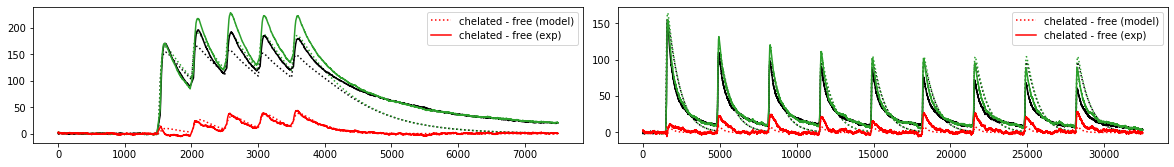

In [284]:
calib_data = load_dict('data/exp_data_for_calibration.npz')

Cdata = load_dict(load_dict('data/best_chelatedZn_config.npz')['filename'])
    
sim_data = load_dict('./'+load_dict('./data/calib/best-freeZn-config%s.npz' % SUFFIX)['filename'])
        
fig2, AXmape = ge.figure(axes=(2,1), figsize=(3,3), wspace=0.1)
Residual = 1

for cond, ax in zip(['20Hz_protocol', '3Hz_protocol'], AXmape):

    tcond = (sim_data['t']>(sim_data['%s_tstart' % cond]-calib_data['DT0_%s' % cond])) &\
        (sim_data['t']<sim_data['%s_tstart' % cond]-calib_data['DT0_%s' % cond]+\
         calib_data['DTfull_%s' % cond])
    
    trace_model = -1e3*(sim_data['Ic'][tcond]-sim_data['Ic'][tcond][0]) # - sign
    trace_model0 = -1e3*(Cdata['Ic'][tcond]-Cdata['Ic'][tcond][0])
    ax.plot(trace_model, ':', color='k')
    ax.plot(trace_model0, ':', color=ge.green)
    trace_exp = calib_data['Iexp_freeZn_%s' % cond]
    trace_exp0 = calib_data['Iexp_chelatedZn_%s' % cond]
    first_peak_cond = (calib_data['t_%s' % cond]<calib_data['DT0_%s' % cond]+50)# normalizing to peak in the exp
    factor_exp = np.max(trace_exp[first_peak_cond])
    factor_exp0 = np.max(trace_exp0[first_peak_cond])
    trace_exp *= factor_exp0/factor_exp
    ax.plot(trace_exp, color='k')
    ax.plot(trace_exp0, color=ge.green)
    diff_model = trace_model0-trace_model
    diff_exp = trace_exp0-trace_exp

    ax.plot(diff_model, ':', color='r', label='chelated - free (model)')
    ax.plot(diff_exp, color='r', label='chelated - free (exp)')
    print(cond, ' -> Variance explained: %.1f%%' % (100*(1-np.std(diff_model-diff_exp)/np.std(diff_exp))))
    print(cond, ' -> Model-Exp cross-correl: %.2f' % np.corrcoef(diff_model,diff_exp)[0][1])
    DTsmoothing = 150
    print(cond, ' -> Variance explained: %.1f%%' % (100*(1-np.std(np.abs(diff_model-gaussian_smoothing(diff_exp,DTsmoothing)))/np.std(gaussian_smoothing(diff_exp,DTsmoothing)))))
    print(np.std(np.abs(diff_model-diff_exp))/np.std(diff_exp)**2)
    ax.legend()



1